<a href="https://colab.research.google.com/github/b3vedi/LABS/blob/main/Heartbeat_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Dataset

Considering only more than 3 sec files and
labelling the files as Normal or Abnormal

In [ ]:
import os
import glob

def get_all_files(root_dir, pattern):
    # Walk through the directory tree and return all files matching the pattern
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in glob.iglob(os.path.join(dirpath, pattern)):
            yield filename

# Initialize an empty list to store the dataset
dataset = []

# Set the directory containing the dataset
dataset_dir = "./drive/MyDrive/HeartbeatClassifier"

# Set the file pattern to match all .wav files in all subdirectories
pattern = "**/*.wav"

# Iterate through all .wav files in the dataset directory and its subdirectories
for filename in get_all_files(dataset_dir, pattern):
    # Extract the label from the filename
    label = filename.split("/")[-2].split("_")[-1]
    # Get the duration of the audio file
    duration = librosa.get_duration(filename=filename)

    # Skip audio files shorter than 3 seconds
    if duration >= 3:
        # Set the length of each slice
        slice_size = 3

        # Calculate the number of iterations needed to cover the entire audio file
        iterations = int((duration-slice_size)/(slice_size-1))
        iterations += 1

        # Calculate the initial offset for the first slice
        initial_offset = (duration - ((iterations*(slice_size-1))+1))/2

        # Only include files with specific labels
        if label not in ["Aunlabelledtest", "Bunlabelledtest", "artifact"]:
            # Iterate through each slice of the audio file
            for i in range(iterations):
                offset = initial_offset + i*(slice_size-1)

                # Add the slice to the dataset with its corresponding label and offset
                if ("normal" in label.lower()):
                    dataset.append({
                        "filename": filename,
                        "label": "normal",
                        "offset": offset
                    })
                else:
                    dataset.append({
                        "filename": filename,
                        "label": "abnormal",
                        "offset": offset
                    })

# Convert the dataset list to a pandas DataFrame and shuffle the rows randomly
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)

# Print the summary of the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1281 entries, 1241 to 1126
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1281 non-null   object 
 1   label     1281 non-null   object 
 2   offset    1281 non-null   float64
dtypes: float64(1), object(2)
memory usage: 40.0+ KB


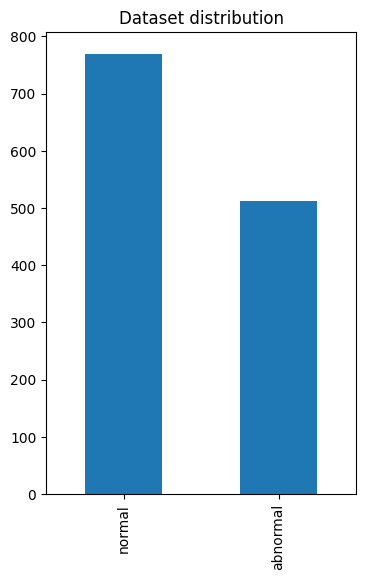

In [ ]:
# Create a new figure with a specific size
plt.figure(figsize=(4,6))

# Count the number of instances for each unique label in the dataset and plot the results as a bar chart
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")

# Display the plot
plt.show()

## Split dataset in train and test
80-20 Ratio

In [ ]:
# Split the dataset into training and testing sets using train_test_split method from scikit-learn
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

# Print the lengths of the training and testing sets
print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 1024
Test: 257


## Visualising the data and features

./drive/MyDrive/HeartbeatClassifier/set_a/Atraining_normal/201105021804.wav
./drive/MyDrive/HeartbeatClassifier/set_a/Atraining_extrahls/201101091153.wav


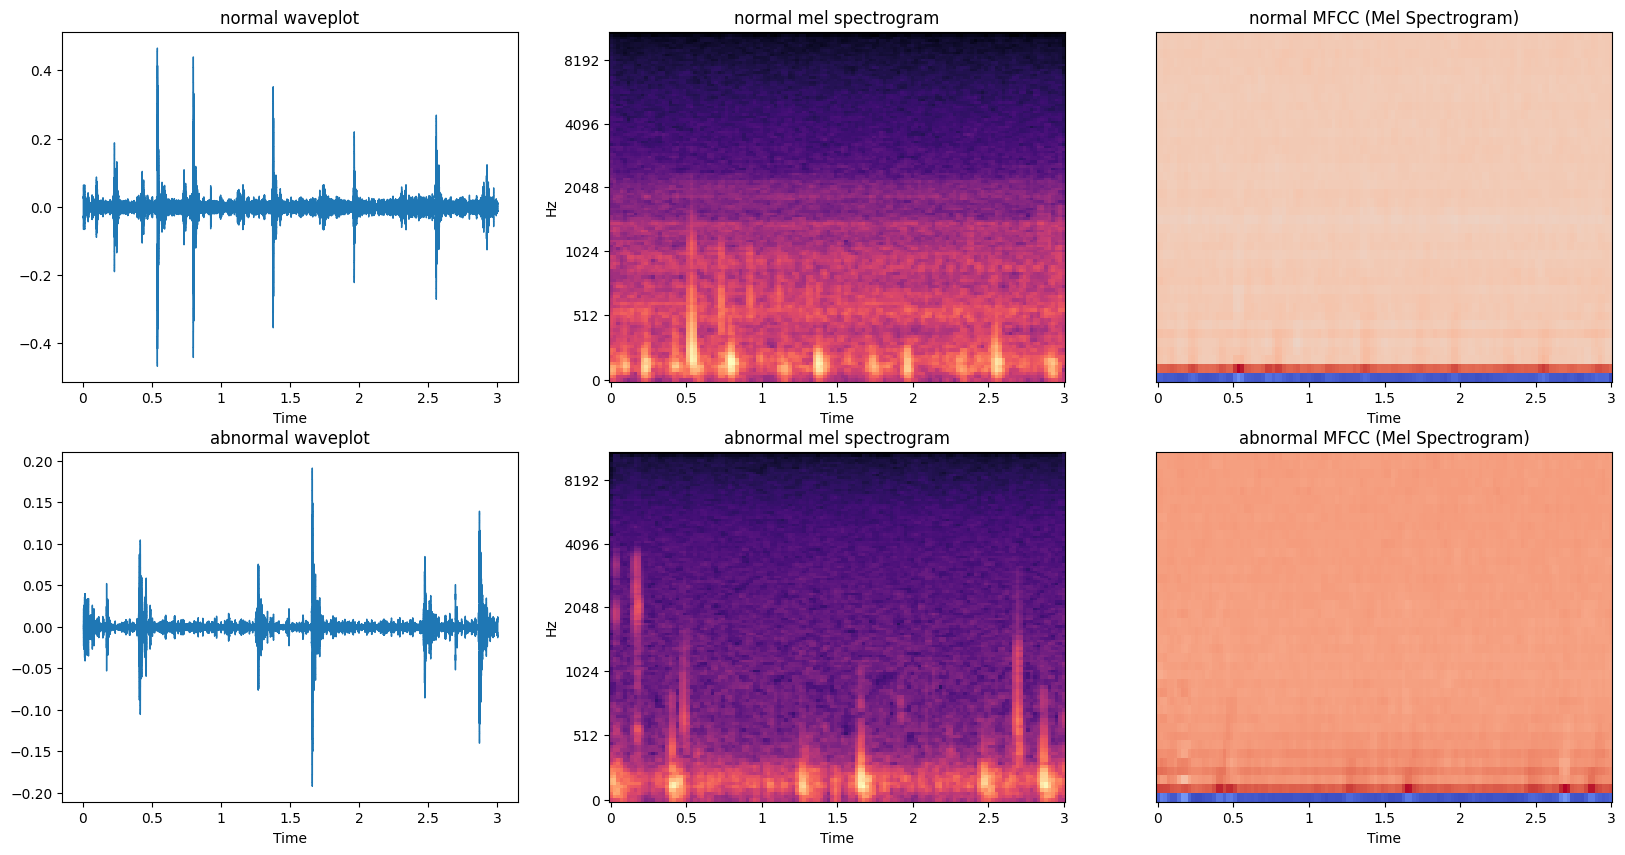

In [ ]:
# Setting the figure size for the plot
plt.figure(figsize=(20,10))

# Initializing a variable to keep track of the plot index
idx = 0

# Looping through each unique label in the dataset
for label in dataset.label.unique():
    # Loading an audio file for the current label
    # The 'duration' argument specifies the length of the audio segment to load
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[33], duration=3)
    print(dataset[dataset.label==label].filename.iloc[33])

    # Plotting the wave plot for the audio file
    idx+=1
    plt.subplot(2, 3, idx)
    plt.title("%s waveplot" % label)
    librosa.display.waveshow(y, sr=sr)

    # Computing and plotting the mel spectrogram for the audio file
    idx+=1
    plt.subplot(2, 3, idx)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.title("%s mel spectrogram" % label)

    # Computing and plotting the MFCC (Mel Frequency Cepstral Coefficients) for the audio file
    idx+=1
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    plt.subplot(2, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s MFCC (Mel Spectrogram)" % label)

# Displaying the final plot
plt.show()

## Extracting features

In [ ]:
# Defining a function to extract features from an audio file
def extract_features(audio_path, offset):
    # Loading the audio file using Librosa library
    # The 'offset' argument specifies the start position in seconds
    # The 'duration' argument specifies the length of the audio segment to load
    y, sr = librosa.load(audio_path, offset=offset, duration=3)

    # Computing the mel-scaled spectrogram of the audio signal using Librosa library
    # The 'n_fft' argument specifies the length of the FFT window
    # The 'hop_length' argument specifies the number of samples between consecutive frames
    # The 'n_mels' argument specifies the number of Mel bands to generate
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048,
                                   hop_length=512,
                                   n_mels=128)

    # Computing the Mel-frequency cepstral coefficients (MFCCs) of the spectrogram
    # The 'n_mfcc' argument specifies the number of MFCCs to compute
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)

    # Returning the MFCCs as the extracted features
    return mfccs

# Initializing empty lists for storing extracted features
x_train = []
x_test = []

# Looping through the training data and extracting features for each audio file
for idx in tqdm(range(len(train))):
    # Extracting features for the current audio file and appending to the 'x_train' list
    x_train.append(extract_features(train.filename.iloc[idx], train.offset.iloc[idx]))

# Looping through the testing data and extracting features for each audio file
for idx in tqdm(range(len(test))):
    # Extracting features for the current audio file and appending to the 'x_test' list
    x_test.append(extract_features(test.filename.iloc[idx], test.offset.iloc[idx]))

# Converting the 'x_train' and 'x_test' lists to NumPy arrays
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

# Printing the shape of the 'x_train' and 'x_test' arrays
print("X train:", x_train.shape)
print("X test:", x_test.shape)

100%|██████████| 257/257 [00:08<00:00, 30.47it/s]

X train: (1024, 40, 130)
X test: (257, 40, 130)


In [ ]:
# Encode Labels
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
class_weights = {i:w for i,w in enumerate(class_weights)}

## Input Shapes

In [ ]:
# Reshape training and testing input data to include an additional dimension for the number of channels
# In this case, the number of channels is 1 because we are using a grayscale image
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

# Convert target variables into one-hot encoding format
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Print the shape of the input and target variables for training and testing data
print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (1024, 40, 130, 1)
Y train: (1024, 2)
X test: (257, 40, 130, 1)
Y test: (257, 2)


## Building Model

In [ ]:
# Create a sequential model object
model = Sequential()

# Add a convolutional layer with 16 filters and 2x2 kernel size with 'relu' activation function
# The input shape is (number of samples, height of each image, width of each image, number of channels)
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))

# Add a max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=2))

# Add a dropout layer with 0.2 probability to prevent overfitting
model.add(Dropout(0.2))

# Add another convolutional layer with 32 filters and 2x2 kernel size with 'relu' activation function
model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))

# Add another max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=2))

# Add another dropout layer with 0.2 probability to prevent overfitting
model.add(Dropout(0.2))

# Add another convolutional layer with 64 filters and 2x2 kernel size with 'relu' activation function
model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))

# Add another max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=2))

# Add another dropout layer with 0.2 probability to prevent overfitting
model.add(Dropout(0.2))

# Add another convolutional layer with 128 filters and 2x2 kernel size with 'relu' activation function
model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))

# Add another max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=2))

# Add another dropout layer with 0.5 probability to prevent overfitting
model.add(Dropout(0.5))

# Add a global average pooling layer to reduce the spatial dimensions of the output
model.add(GlobalAveragePooling2D())

# Add a fully connected dense layer with number of units equal to the number of classes in the target variable
# The activation function is 'softmax' to output class probabilities
model.add(Dense(len(encoder.classes_), activation='softmax'))

# Print the summary of the model architecture
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 39, 129, 16)       80        
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 19, 64, 16)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 19, 64, 16)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 18, 63, 32)        2080      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 9, 31, 32)        0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 9, 31, 32)        

## Compiling Model

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.001)  # create Adam optimizer with learning rate 0.001
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')  # compile the model with Adam optimizer, categorical crossentropy loss function and accuracy metric

## Fitting Model

In [ ]:
# Measure the time it takes to train the model
%%time

# Train the model using the fit method
history = model.fit(
    # x_train and y_train are the input and output data for training
    x_train, y_train,
    # The number of samples per gradient update
    batch_size=128,
    # The number of epochs to train the model. An epoch is an iteration over the entire training data.
    epochs=300,
    # The data used for validation during training.
    validation_data=(x_test, y_test),
    class_weight = class_weights,
    # Whether to shuffle the training data before each epoch.
    shuffle=True
)

Epoch 1/300
8/8 [==============================] - 9s 833ms/step - loss: 4.8948 - accuracy: 0.5391 - val_loss: 0.8710 - val_accuracy: 0.6109
Epoch 2/300
8/8 [==============================] - 4s 527ms/step - loss: 2.8736 - accuracy: 0.4629 - val_loss: 1.2418 - val_accuracy: 0.5837
Epoch 3/300
8/8 [==============================] - 4s 548ms/step - loss: 1.7339 - accuracy: 0.5596 - val_loss: 0.7116 - val_accuracy: 0.6109
Epoch 4/300
8/8 [==============================] - 6s 732ms/step - loss: 1.1165 - accuracy: 0.5723 - val_loss: 0.6498 - val_accuracy: 0.6304
Epoch 5/300
8/8 [==============================] - 4s 519ms/step - loss: 0.8848 - accuracy: 0.6289 - val_loss: 0.6531 - val_accuracy: 0.6265
Epoch 6/300
8/8 [==============================] - 4s 522ms/step - loss: 0.7997 - accuracy: 0.5615 - val_loss: 0.6385 - val_accuracy: 0.6304
Epoch 7/300
8/8 [==============================] - 6s 795ms/step - loss: 0.7448 - accuracy: 0.6084 - val_loss: 0.6350 - val_accuracy: 0.6420
Epoch 8/300
8

## Evaluating model

Text(0.5, 1.0, 'Accuracy Curves')

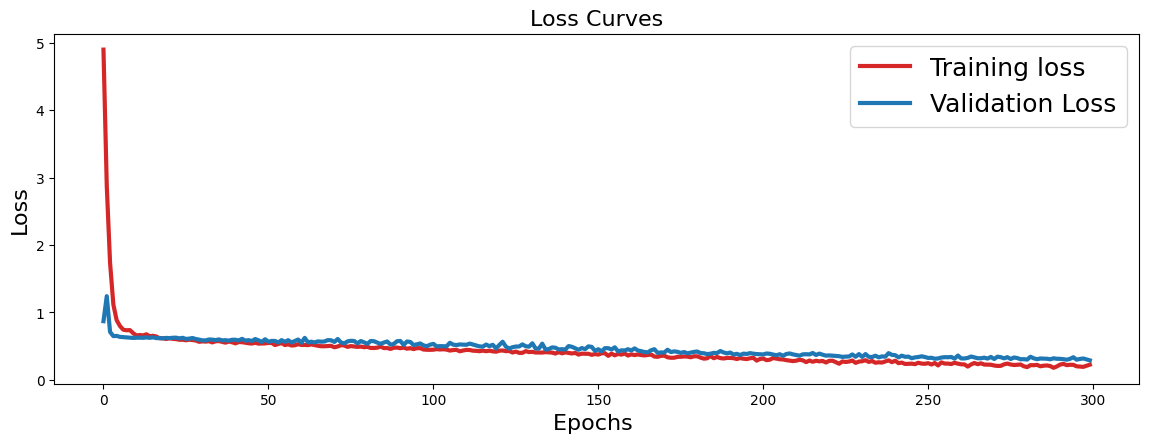

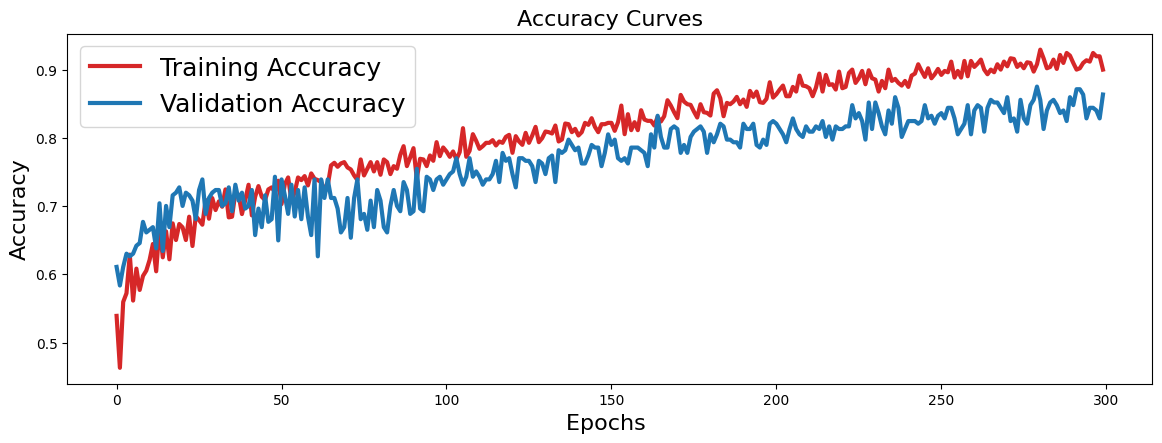

In [ ]:
# Creating a figure with two subplots
# The first subplot shows the loss curves
plt.figure(figsize=[14,10])
plt.subplot(211)

# Plotting the training and validation loss values for each epoch
plt.plot(history.history['loss'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_loss'],'#1f77b4',linewidth=3.0)

# Adding a legend to the plot and setting the font size
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)

# Adding labels to the x-axis and y-axis and setting the font size
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)

# Adding a title to the plot and setting the font size
plt.title('Loss Curves',fontsize=16)

# The second subplot shows the accuracy curves
plt.figure(figsize=[14,10])
plt.subplot(212)

# Plotting the training and validation accuracy values for each epoch
plt.plot(history.history['accuracy'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'#1f77b4',linewidth=3.0)

# Adding a legend to the plot and setting the font size
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)

# Adding labels to the x-axis and y-axis and setting the font size
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)

# Adding a title to the plot and setting the font size
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
# Evaluating the trained model on the test data
# x_test is the input data, y_test is the ground truth labels
scores = model.evaluate(x_test, y_test, verbose=1)

# Printing the test loss (the average loss value for all samples in the test set)
# scores[0] contains the test loss value
print('Test loss:', scores[0])

# Printing the test accuracy (the proportion of correctly classified samples in the test set)
# scores[1] contains the test accuracy value
print('Test accuracy:', scores[1])

9/9 [==============================] - 1s 72ms/step - loss: 0.2906 - accuracy: 0.8638
Test loss: 0.2906222939491272
Test accuracy: 0.8638132214546204


In [ ]:
# Predicting the labels for the test data using the trained model
# x_test is the input data
predictions = model.predict(x_test, verbose=1)

# Initializing empty lists for storing the true and predicted labels
y_true, y_pred = [], []

# Getting the class labels from the encoder
classes = encoder.classes_

# Looping through the predictions and adding the corresponding true and predicted labels to the lists
for idx, prediction in enumerate(predictions):
    # Getting the true label from y_test and adding it to y_true
    y_true.append(classes[np.argmax(y_test[idx])])

    # Getting the predicted label from the prediction and adding it to y_pred
    y_pred.append(classes[np.argmax(prediction)])

# Printing the classification report, which contains precision, recall, and F1-score for each class
# y_pred contains the predicted labels, y_true contains the ground truth labels
print(classification_report(y_pred, y_true))

9/9 [==============================] - 0s 32ms/step
              precision    recall  f1-score   support

    abnormal       0.83      0.84      0.84       107
      normal       0.89      0.88      0.88       150

    accuracy                           0.86       257
   macro avg       0.86      0.86      0.86       257
weighted avg       0.86      0.86      0.86       257



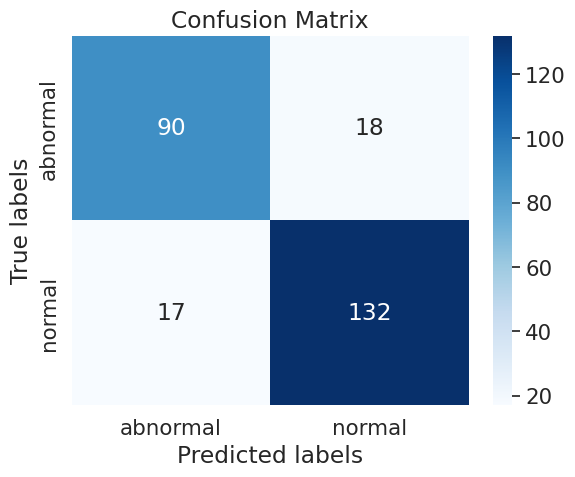

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=classes)

# Creating the heatmap using seaborn
sns.set(font_scale=1.4) # Adjust font size
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Adding labels to the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Save Model and Weights

In [ ]:
# Define a variable for the model file name
model_name = "heartbeat_classifier.h5"

# Save the trained model to a file with the specified name
model.save(f"./drive/MyDrive/HeartbeatClassifier/{model_name}")

In [ ]:
# 1 sec overlap
# Trained for 3sec for files >3sec

### Classifying an heart beat

In [ ]:
from keras.models import load_model

# load the pre-trained model
model = load_model("./drive/MyDrive/HeartbeatClassifier/heartbeat_classifier.h5")

# specify the audio file to be classified
classify_file = "./drive/MyDrive/HeartbeatClassifier/my_heartbeat.wav"

# extract audio features and prepare the data for the model input
x_test = []
x_test.append(extract_features(classify_file, 0.5))
x_test = np.asarray(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

# predict the class of the audio file using the pre-trained model
pred = model.predict(x_test, verbose=1)

# print the predicted class probabilities
print(pred)

1/1 [==============================] - 0s 399ms/step
[[0.43824166 0.56175834]]


In [ ]:
# predict the class of the audio file using the pre-trained model
predict_x = model.predict(x_test)
pred_class = np.argmax(predict_x, axis=1)

# if the predicted class is 1, output "Normal heartbeat" with the confidence score
if pred_class[0]:
    print("Normal heartbeat")
    print("confidence:",pred[0][1])

# otherwise, output "Abnormal heartbeat" with the confidence score
else:
    print("Abnormal heartbeat")
    print("confidence:",pred[0][0])

1/1 [==============================] - 0s 38ms/step
Normal heartbeat
confidence: 0.99654096
